In [1]:
from data.marco import get_sentences
from model.word2vec import get_model, train_model
from gensim.utils import simple_preprocess

raw_sentences = get_sentences()
tokenized_sentences = [simple_preprocess(sentence) for sentence in raw_sentences]
skipgram_model = get_model(tokenized_sentences)
train_model(skipgram_model, tokenized_sentences)

model_path = "./artifacts/word2vec-300.bin"
skipgram_model.save(model_path)

/home/eli/miniconda3/envs/search/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


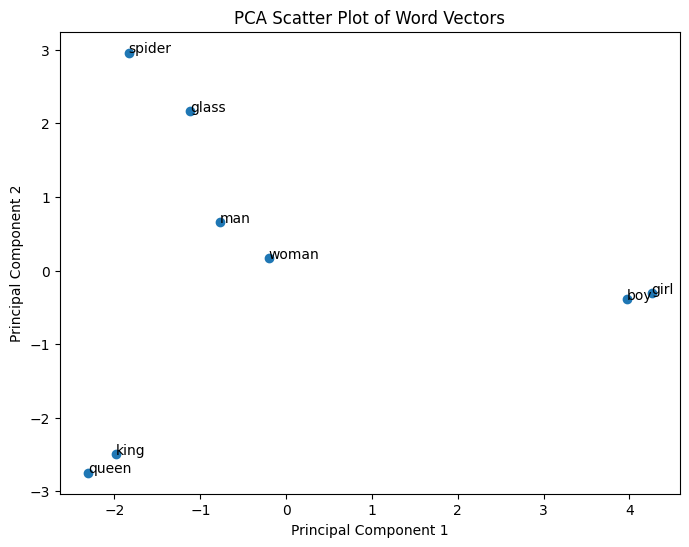

In [4]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

model_path = "./artifacts/word2vec-300.bin"
model = Word2Vec.load(model_path)
# model.wv['what']



plot_words = ["king", "queen", "man", "woman", "glass", "boy","girl", "spider"]


## apply PCA
word_matrix = np.array([model.wv[word] for word in plot_words])
num_components = 3  # Number of principal components to keep
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(word_matrix)
pca_result

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o')

# Annotate points with the corresponding words
for i, word in enumerate(plot_words):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]))

# Add labels and a title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot of Word Vectors")

# Show the plot
plt.show()


In [3]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate(batch):
    # Unzip the batch into lists of queries, relevant_docs, and irrelevant_docs
    query_emb_list, relevant_doc_emb_list, irrelevant_doc_emb_list = zip(*batch)
    
    # Pad sequences for relevant and irrelevant documents
    # This assumes each document is already a tensor of embeddings; adjust if the structure is different
    padded_relevant = pad_sequence([pad_sequence(docs, batch_first=True) for docs in relevant_doc_emb_list], batch_first=True)
    padded_irrelevant = pad_sequence([pad_sequence(docs, batch_first=True) for docs in irrelevant_doc_emb_list], batch_first=True)
    
    # Pad the sequences of query embeddings
    query_emb_tensor = pad_sequence(query_emb_list, batch_first=True)

    return query_emb_tensor, padded_relevant, padded_irrelevant

In [2]:
# HYPERPARAMETERS

vocab_size = 16000  # Number of tokens in the vocabulary
embedding_dim = 300  # The dimension of the word embeddings
window_size = 6  # The context size
hidden_dim = 512
batch_size = 32
learning_rate = 0.001
epochs = 10
experiment_number = 1
margin = 0.3


In [8]:
wandb.finish()

epoch,▁
loss,▁
epoch,0
loss,0.3


In [9]:
from model.twotowermodel import DocumentTower, QueryTower
from data.dataset import QueryDocumentDataset
from data.marco import get_training_dataset, get_validation_dataset, get_test_dataset
from torch.optim import Adam
from torch.utils.data import DataLoader
from utils.loss_function import distance_function
import torch
import wandb
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device', device)

# Initialize model and optimizer
document_model = DocumentTower(embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)
query_model = QueryTower(embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

if os.path.exists('document_model_state_dict1.pth'):
    print("File exists.")
    document_model.load_state_dict(torch.load('document_model_state_dict1.pth'))
    query_model.load_state_dict(torch.load('query_model_state_dict1.pth'))

# start a new wandb run to track this script
run = wandb.init(
    # set the wandb project where this run will be logged
    project="document_search",
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "batch_size": batch_size,
    "word2vec_model": "skip-gram",
    "word2vec_window_size": window_size,
    "epochs": epochs,
    },
    mode="offline"
)



optimizer = Adam(list(document_model.parameters()) + list(query_model.parameters()), lr=learning_rate)
criterion = torch.nn.TripletMarginWithDistanceLoss(distance_function=distance_function, margin=margin)


dataset_instance = QueryDocumentDataset(data=get_training_dataset(), embedding_model=model)
dataloader = DataLoader(dataset_instance, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)  # You can adjust batch_size as needed
val_dataset = QueryDocumentDataset(data=get_training_dataset(), embedding_model=model)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)


counter = 0
print('starting training')
for epoch in range(epochs):

    document_model.train()
    query_model.train()
    train_loss = 0
    for query_emb, relevant_doc_emb, irrelevant_doc_emb in dataloader:
        # Convert the tokens to embeddings
        # Forward pass to get encodings for two tower
        query_emb = query_emb.to(device)
        relevant_doc_emb = relevant_doc_emb.to(device)
        irrelevant_doc_emb = irrelevant_doc_emb.to(device)

        # Zero out the parameter gradients 
        optimizer.zero_grad()

        # forward pass
        relevant_doc_encoding, irrelevant_doc_encoding = document_model(relevant_doc_emb, irrelevant_doc_emb)
        query_encoding = query_model(query_emb)

        # Compute triplet loss
        loss = criterion(query_encoding, relevant_doc_encoding, irrelevant_doc_encoding)

        # Backpropagation
        loss.backward() # Compute gradient of loss wrt all the parameters in loss
        optimizer.step() # Update parameters

        if counter % 500 == 0:
            print(f"Triplet loss: {loss.item()}")
            wandb.log({"epoch": epoch, "loss": loss.item()})
            
        counter += 1
    
    counter = 0

    # Validation
    document_model.eval()
    query_model.eval()
    with torch.no_grad():
        total_loss = 0
        for val_queries, val_positive_documents, val_negative_documents in val_data_loader:
            batch_size = query_emb.size(0)

            query_emb = val_queries.to(device)
            relevant_doc_emb = val_positive_documents.to(device)
            irrelevant_doc_emb = val_negative_documents.to(device)

            relevant_doc_encoding, irrelevant_doc_encoding = document_model(relevant_doc_emb, irrelevant_doc_emb)
            query_encoding = query_model(query_emb)

            loss = criterion(query_encoding, relevant_doc_encoding, irrelevant_doc_encoding)
            total_loss += loss.item() * batch_size

        avg_loss = total_loss / len(val_data_loader)
        print(f"Triplet loss: {avg_loss}")
        wandb.log({"val_loss": avg_loss})
        
    torch.save(document_model.state_dict(), f'document_model_state_dict{experiment_number}.pth')
    torch.save(query_model.state_dict(), f'query_model_state_dict{experiment_number}.pth')

wandb.finish()

device cuda
File exists.


starting training
Triplet loss: 0.3000025749206543
Triplet loss: 0.2621687650680542
Triplet loss: 0.28486835956573486
Triplet loss: 0.30000007152557373
Triplet loss: 0.27729833126068115
Triplet loss: 0.2924356460571289
Triplet loss: 9.605742558634239
Triplet loss: 0.2999994158744812
Triplet loss: 0.29243239760398865
Triplet loss: 0.30756786465644836
Triplet loss: 0.29243189096450806
Triplet loss: 0.2999999523162842
Triplet loss: 0.2848634719848633
Triplet loss: 9.609335742407257
Triplet loss: 0.2772951126098633
Triplet loss: 0.2772951126098633
Triplet loss: 0.28486332297325134
Triplet loss: 0.3075683116912842
Triplet loss: 0.2772951126098633
Triplet loss: 0.30000007152557373
Triplet loss: 9.604518035576588
Triplet loss: 0.2772950530052185
Triplet loss: 0.2848632335662842
Triplet loss: 0.2999999523162842
Triplet loss: 0.30756843090057373
Triplet loss: 0.2772948443889618
Triplet loss: 0.3075683116912842
Triplet loss: 9.592367196703902
Triplet loss: 0.2924315929412842
Triplet loss: 0.2848

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,▅▂▅▃▅▄▄▅▃▃▅▃▃▃▅▃▄▃▅▆▃▂▆▄▅▁▅▃▄▂▆▅▅▄▅▃▆▂█▄
val_loss,▇█▆▁▂▅▃▅▄▇
epoch,9
loss,0.29268
val_loss,9.60685


In [21]:
torch.save(document_model.state_dict(), f'document_model_state_dict{experiment_number}.pth')
torch.save(query_model.state_dict(), f'query_model_state_dict{experiment_number}.pth')

In [10]:
def threshold_similarity(batch1, batch2):
    # Compute cosine similarity between batch1 and batch2
    similarity = distance_function(batch1, batch2)

    # Set similarity to 1 (relevant) if positive, 0 (irrelevant) if negative
    threshold_similarity = torch.where(similarity > 0, torch.tensor(1), torch.tensor(0))

    return threshold_similarity

test_dataset = QueryDocumentDataset(data=get_test_dataset(), embedding_model=model)
test_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

document_model.eval()
query_model.eval()
with torch.no_grad():
    test_loss = 0
    test_accuracy = 0
    
    for test_queries, test_positive_documents, test_negative_documents in test_data_loader:
        test_queries, test_positive_documents, test_negative_documents = test_queries.to(device), test_positive_documents.to(device), test_negative_documents.to(device)

        relevant_doc_encoding, irrelevant_doc_encoding = document_model(relevant_doc_emb, irrelevant_doc_emb)
        query_encoding = query_model(query_emb)        
        test_loss += criterion(query_encoding, relevant_doc_encoding, irrelevant_doc_encoding)
    
        test_positive_accuracy = torch.mean(threshold_similarity(query_encoding, relevant_doc_encoding).float())
        test_negative_document_encodings =  torch.mean(1 - threshold_similarity(query_encoding, irrelevant_doc_encoding).float())
        test_accuracy += (test_positive_accuracy + test_negative_document_encodings)/2
        
    test_loss /= len(test_data_loader)
    test_accuracy /= len(test_data_loader)

# Print the loss and accuracy for the test set    
print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy.item():.4f}')

Test Loss: 0.3000, Test Accuracy: 0.5000
